In [1]:
# Import Dependencies 
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import quandl
import numpy as np
import pandas as pd
import time
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from statsmodels.tsa.stattools import coint
from scipy import stats
import requests
from bs4 import BeautifulSoup

# API keys
quandl.ApiConfig.api_key = 'n8ytM4yxbemwLYG_yrRa'

In [6]:
# Gather fundamentals
fundamentals = quandl.get_table("SHARADAR/TICKERS", paginate=True)
fundamentals

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
None,,,,,,,,,,,,,,,,,,,,,
0,SF1,196290,A,Agilent Technologies Inc,NYSE,N,Domestic,00846U101,3826.0,Manufacturing,...,USD,California; U.S.A,2019-12-20,2014-09-26,1999-11-18,2020-02-18,1997-06-30,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.agilent.com
1,SF1,124392,AA,Alcoa Corp,NYSE,N,Domestic,013872106,3350.0,Manufacturing,...,USD,New York; U.S.A,2019-11-01,2016-11-01,2016-11-01,2020-02-18,2014-12-31,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.alcoa.com
2,SF1,122827,AAAB,Admiralty Bancorp Inc,NASDAQ,Y,Domestic,007231103,6022.0,Finance Insurance And Real Estate,...,USD,Florida; U.S.A,2019-07-29,2017-09-09,1998-09-25,2003-01-28,1997-09-30,2002-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,None
3,SF1,120538,AAAGY,Altana Aktiengesellschaft,NYSE,Y,ADR,02143N103,2834.0,Manufacturing,...,EUR,Jordan,2019-05-17,2018-02-13,2002-05-22,2010-08-12,2000-12-31,2005-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,None
4,SF1,155760,AAAP,Advanced Accelerator Applications SA,NASDAQ,Y,ADR,00790T100,2834.0,Manufacturing,...,EUR,France,2019-08-30,2016-05-19,2015-11-11,2018-02-09,2012-12-31,2016-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36223,SFP,111633,^DJI,Dow Jones Industrial Average,INDEX,N,IDX,None,NaN,None,...,USD,None,2020-02-18,2019-02-03,1986-01-01,2020-02-18,None,None,None,None
36224,SFP,111631,^GSPC,S&P 500,INDEX,N,IDX,None,NaN,None,...,USD,None,2020-02-18,2019-02-03,1986-01-01,2020-02-18,None,None,None,None
36225,SFP,111632,^IXIC,NASDAQ Composite,INDEX,N,IDX,None,NaN,None,...,USD,None,2020-02-18,2019-02-03,1986-01-01,2020-02-18,None,None,None,None


In [3]:
# Select wanted columns | reset index | Drop Empty Rows | Delete Duplicates
fundamentals = fundamentals[['ticker','scalemarketcap', 'scalerevenue','siccode']]
fundamentals = fundamentals.reset_index()
fundamentals = fundamentals.dropna(axis=0, how='all', thresh=None, subset=None, inplace=False)
fundamentals = fundamentals.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

# Change Values into numbers only
fundamentals['scalemarketcap'] = fundamentals['scalemarketcap'].str[:2]
fundamentals['scalerevenue'] = fundamentals['scalerevenue'].str[:2]

# Turn into numeric float types
fundamentals['scalerevenue'] = fundamentals['scalerevenue'].astype(float)
fundamentals['scalemarketcap'] = fundamentals['scalemarketcap'].astype(float)

fundamentals = fundamentals.drop_duplicates(subset='ticker')
fundamentals


,None,ticker,scalemarketcap,scalerevenue,siccode
0,0,A,5.0,5.0,3826.0
1,1,AA,4.0,5.0,3350.0
2,2,AAAB,2.0,1.0,6022.0
3,3,AAAGY,4.0,4.0,2834.0
4,4,AAAP,3.0,2.0,2834.0
...,...,...,...,...,...
14537,14537,ZYME,3.0,2.0,2834.0
14538,14538,ZYNE,2.0,1.0,2834.0
14539,14539,ZYTO,1.0,1.0,3841.0
14540,14540,ZYXI,3.0,1.0,3845.0


In [4]:
# Get list of tickers in Fundamentals Table
ticker_list = fundamentals['ticker']
print("Tickers to query:", len(ticker_list))

Tickers to query: 13956


In [5]:
# Gather equity prices
dataframes_list = []
for stock in ticker_list:
    try:
        equity_prices = quandl.get(f'EOD/{stock}',start_date='2018-02-02', end_date='2020-02-02',paginate=True)
        equity_prices = equity_prices.iloc[:,:1]
        equity_prices = equity_prices.rename(columns={"Open": f"{stock}"})
        
        if equity_prices.shape[0] != 0:
            dataframes_list.append(equity_prices)

        else:
            pass
        

    except:
         continue
            
equity_prices = pd.concat(dataframes_list, axis=1)    
print('----------------Data Collection Done-------------------')

equity_prices

----------------Data Collection Done-------------------


,A,AA,AAAP,AAC,AACG,AAL,AAMC,AAME,AAN,AAOI,...,ZS,ZSAN,ZTO,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,72.32,52.00,80.49,8.56,4.8800,53.49,67.7000,3.60,40.53,33.61,...,NaN,6.31,16.090,77.53,20.80,NaN,7.79,13.1200,11.65,NaN
2018-02-05,70.86,48.61,80.66,8.01,4.8000,51.99,67.7000,3.50,38.71,32.50,...,NaN,5.63,15.160,76.64,20.45,NaN,7.49,12.8900,10.90,NaN
2018-02-06,66.96,47.44,80.75,7.96,4.8000,49.32,67.7000,3.35,36.67,32.00,...,NaN,4.84,14.710,72.74,20.10,NaN,7.02,12.1500,10.60,NaN
2018-02-07,68.19,49.23,81.30,8.26,5.9900,50.91,67.7000,3.35,38.37,33.86,...,NaN,4.66,15.450,72.70,20.55,NaN,7.35,12.0354,11.09,NaN
2018-02-08,68.09,47.81,81.68,8.13,6.0000,51.44,69.6500,3.30,39.49,31.30,...,NaN,4.60,15.120,73.96,20.40,NaN,7.20,12.0450,11.60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,86.54,15.01,NaN,NaN,1.3400,26.57,12.8684,1.78,60.49,13.47,...,55.55,1.34,21.715,134.42,31.28,15.00,1.66,46.4200,5.18,9.86
2020-01-28,86.85,15.10,NaN,NaN,1.3253,26.36,13.3000,1.81,61.77,13.35,...,56.52,1.30,22.350,136.14,31.91,15.15,1.64,44.0400,5.26,9.94
2020-01-29,87.55,14.83,NaN,NaN,1.2100,26.88,13.3400,2.22,63.04,12.89,...,56.93,1.27,22.500,138.97,32.45,15.13,1.60,44.5400,5.18,10.57


In [15]:
# Clean Prices | Replace and drop Nas 
equity_prices = equity_prices.replace([np.inf, -np.inf], np.nan)
equity_prices = equity_prices.dropna(axis=1, how='all')
equity_prices = equity_prices.dropna(axis=1, how='any')
print("---Prices---")
equity_prices

---Prices---


,A,AA,AACG,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,...,ZKIN,ZLAB,ZNGA,ZNH,ZSAN,ZTO,ZTS,ZUMZ,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,72.32,52.00,4.8800,53.49,67.7000,3.60,40.53,33.61,35.95,115.92,...,8.90,26.30,3.68,64.70,6.31,16.090,77.53,20.80,13.1200,11.65
2018-02-05,70.86,48.61,4.8000,51.99,67.7000,3.50,38.71,32.50,35.40,113.05,...,8.34,25.83,3.55,67.94,5.63,15.160,76.64,20.45,12.8900,10.90
2018-02-06,66.96,47.44,4.8000,49.32,67.7000,3.35,36.67,32.00,33.40,108.28,...,7.11,25.19,3.46,63.20,4.84,14.710,72.74,20.10,12.1500,10.60
2018-02-07,68.19,49.23,5.9900,50.91,67.7000,3.35,38.37,33.86,33.55,112.09,...,7.27,23.00,3.60,60.75,4.66,15.450,72.70,20.55,12.0354,11.09
2018-02-08,68.09,47.81,6.0000,51.44,69.6500,3.30,39.49,31.30,33.70,109.93,...,7.71,22.50,3.85,60.00,4.60,15.120,73.96,20.40,12.0450,11.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,86.54,15.01,1.3400,26.57,12.8684,1.78,60.49,13.47,52.35,139.89,...,1.65,53.08,6.05,27.52,1.34,21.715,134.42,31.28,46.4200,5.18
2020-01-28,86.85,15.10,1.3253,26.36,13.3000,1.81,61.77,13.35,53.67,139.78,...,1.58,53.81,5.98,28.01,1.30,22.350,136.14,31.91,44.0400,5.26
2020-01-29,87.55,14.83,1.2100,26.88,13.3400,2.22,63.04,12.89,53.91,139.05,...,1.56,55.02,6.11,28.43,1.27,22.500,138.97,32.45,44.5400,5.18


In [17]:
equity_prices.to_csv('equity_prices.csv')

In [18]:
# Convert prices into percentage change
equity_returns = equity_prices.pct_change()
equity_returns = equity_returns.iloc[1:]
print("---Returns---")
equity_returns

---Returns---


,A,AA,AACG,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,...,ZKIN,ZLAB,ZNGA,ZNH,ZSAN,ZTO,ZTS,ZUMZ,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-05,-0.020188,-0.065192,-0.016393,-0.028043,0.000000,-0.027778,-0.044905,-0.033026,-0.015299,-0.024758,...,-0.062921,-0.017871,-0.035326,0.050077,-0.107765,-0.057800,-0.011479,-0.016827,-0.017530,-0.064378
2018-02-06,-0.055038,-0.024069,0.000000,-0.051356,0.000000,-0.042857,-0.052700,-0.015385,-0.056497,-0.042194,...,-0.147482,-0.024777,-0.025352,-0.069767,-0.140320,-0.029683,-0.050887,-0.017115,-0.057409,-0.027523
2018-02-07,0.018369,0.037732,0.247917,0.032238,0.000000,0.000000,0.046359,0.058125,0.004491,0.035187,...,0.022504,-0.086939,0.040462,-0.038766,-0.037190,0.050306,-0.000550,0.022388,-0.009432,0.046226
2018-02-08,-0.001466,-0.028844,0.001669,0.010411,0.028804,-0.014925,0.029189,-0.075605,0.004471,-0.019270,...,0.060523,-0.021739,0.069444,-0.012346,-0.012876,-0.021359,0.017331,-0.007299,0.000798,0.045987
2018-02-09,-0.024820,-0.026563,-0.040000,-0.033826,-0.029433,-0.045455,-0.020765,0.028115,-0.007418,0.004184,...,0.025940,-0.101778,-0.085714,-0.075833,-0.093478,-0.007937,-0.023391,-0.012255,-0.002906,-0.025000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,-0.032532,-0.079141,-0.088373,-0.079029,-0.028800,-0.096447,-0.012086,-0.060014,-0.027855,-0.067400,...,-0.029412,-0.028551,-0.056162,-0.088742,-0.042857,-0.066824,-0.037244,-0.027968,0.023143,-0.078292
2020-01-28,0.003582,0.005996,-0.010970,-0.007904,0.033540,0.016854,0.021161,-0.008909,0.025215,-0.000786,...,-0.042424,0.013753,-0.011570,0.017805,-0.029851,0.029242,0.012796,0.020141,-0.051271,0.015444
2020-01-29,0.008060,-0.017881,-0.086999,0.019727,0.003008,0.226519,0.020560,-0.034457,0.004472,-0.005222,...,-0.012658,0.022487,0.021739,0.014995,-0.023077,0.006711,0.020787,0.016923,0.011353,-0.015209


In [19]:
equity_returns.to_csv('equity_returns.csv')

In [ ]:
# Select tickers Only in prices tables 
fundamentals_data = pd.DataFrame(equity_returns.columns[:], columns =['ticker'])
fundamentals = fundamentals_data.merge(fundamentals,on="ticker")
fundamentals = fundamentals.dropna(axis=0, how='any')
fundamentals = fundamentals.set_index('ticker')
print("Fundamentals Data")
fundamentals 

In [21]:
fundamentals.to_csv('fundamentals.csv')

In [268]:
# Import Data
equity_prices = pd.read_csv('equity_prices.csv')
equity_prices = equity_prices.set_index("Date")
equity_returns = pd.read_csv('equity_returns.csv')
equity_returns = equity_returns.set_index("Date")
fundamentals = pd.read_csv('fundamentals.csv')
fundamentals = fundamentals.set_index("ticker")

In [269]:
fundamentals.drop(labels='AC', axis=0,inplace=True)
equity_prices.drop('AC', axis=1,inplace=True)
equity_returns.drop('AC', axis=1,inplace=True)


In [271]:
N_PRIN_COMPONENTS = 30
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(equity_returns)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [272]:
pca.components_.T.shape

(4051, 30)

In [273]:
X = np.hstack(
    (pca.components_.T,
     fundamentals['scalemarketcap'][equity_returns.columns].values[:, np.newaxis],
     fundamentals['scalerevenue'][equity_returns.columns].values[:, np.newaxis],
    fundamentals['siccode'][equity_returns.columns].values[:, np.newaxis])
)

print(X.shape)

(4051, 33)


In [274]:
X = preprocessing.StandardScaler().fit_transform(X)
print(X.shape)

(4051, 33)


In [275]:
clf = DBSCAN(min_samples=5)
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

Clusters discovered: 29


In [276]:
# the initial dimensionality of the search was
ticker_count = len(equity_returns.columns)
print("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))


Total pairs possible in universe: 8203275 


In [277]:
clustered_series = pd.Series(index=equity_returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=equity_returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [278]:
CLUSTER_SIZE_LIMIT = 25
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 14
Pairs to evaluate: 1474


In [279]:
X_tsne = TSNE(learning_rate=250, perplexity=25, random_state=1337).fit_transform(X)

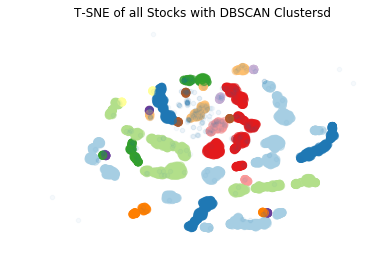

In [280]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=65,
    alpha=0.55,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=20,
    alpha=0.04
)

plt.title('T-SNE of all Stocks with DBSCAN Clustersd');

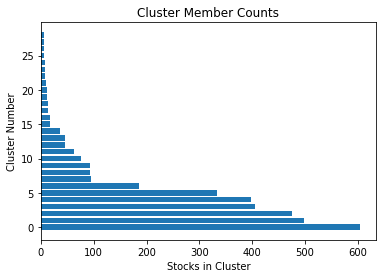

In [281]:
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

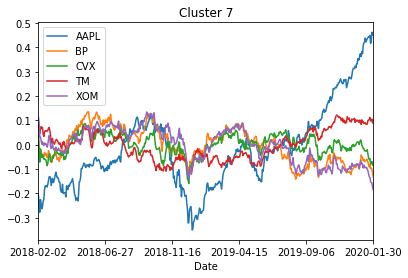

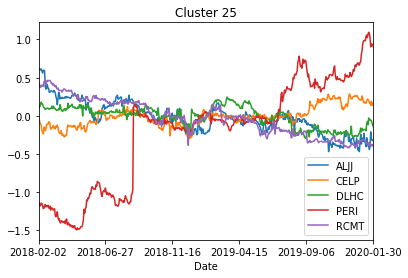

In [282]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# Lisualize a few clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

for clust in cluster_vis_list[0:min(len(cluster_vis_list), 2)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(equity_prices[tickers].mean())
    data = np.log(equity_prices[tickers]).sub(means)
    data.plot(title='Cluster %d' % clust)
    

In [283]:
# Find out which equities relate to APPL
which_cluster = clustered_series.loc[('AAPL')]
clustered_series[clustered_series == which_cluster]

AAPL    7
BP      7
CVX     7
TM      7
XOM     7
dtype: int64

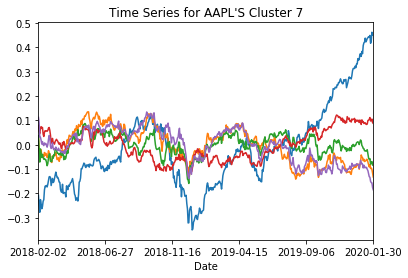

In [284]:
# Visualize Appl's cluster
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(equity_prices[tickers].mean())
data = np.log(equity_prices[tickers]).sub(means)
data.plot(legend=False, title="Time Series for AAPL'S Cluster %d" % which_cluster);

In [297]:
# This function is www.quantopian.com
def find_cointegrated_pairs(data, significance=0.03):
    n = np.array(data.shape[1])
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [298]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        equity_prices[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [299]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [311]:
print("We found %d pairs." % len(pairs), "Lets visualize them with T-SNE")

We found 47 pairs. Lets visualize them with T-SNE


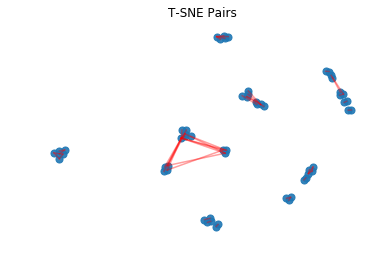

In [307]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=equity_prices.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.38, c='red');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=50, alpha=.9, cmap=cm.Paired)
plt.title('T-SNE Pairs');

In [303]:
pairs_dataframe = pd.DataFrame(pairs, columns =['tickerA', 'tickerB']) 
pairs_dataframe

,tickerA,tickerB
0,ABMD,LBRDA
1,EXTR,FEYE
2,EXTR,GPRO
3,EXTR,IONS
4,EXTR,IPGP
5,EXTR,LBRDA
6,EXTR,PSXP
7,EXTR,ROKU
8,EXTR,SGEN
9,EXTR,SRPT


In [310]:
print("Unique tickers %d unique tickers." % len(np.unique(pairs)))

Unique tickers 58 unique tickers.


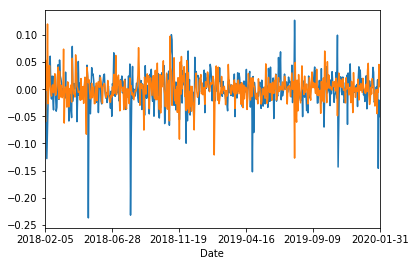

In [305]:

stock1 = pairs[1][0]
stock2 = pairs[1][1]
equity_returns[stock1].plot();
equity_returns[stock2].plot();

In [166]:
# Turn daily returns into Quarterly Returns for Charting purposes
quarterly_returns = equity_returns
quarterly_returns = quarterly_returns.reset_index()
quarterly_returns['Date'] = quarterly_returns['Date'].astype('datetime64[ns]')
quarterly_returns = quarterly_returns.set_index("Date")
quarterly_returns.index = pd.to_datetime(quarterly_returns.index, unit='s')
quarterly_returns = quarterly_returns.resample('Q').mean()
quarterly_returns

,A,AA,AACG,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,...,ZKIN,ZLAB,ZNGA,ZNH,ZSAN,ZTO,ZTS,ZUMZ,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,-0.001829,-0.003648,0.002629,-0.000932,-0.000425,-0.003541,0.003848,-0.007924,0.002235,0.000390,...,-0.006619,-0.005099,0.000526,-0.005266,0.020022,-0.002175,0.001536,0.004091,-0.002002,-0.006990
2018-06-30,-0.001047,0.000895,-0.000467,-0.004373,0.001489,-0.003087,-0.000466,0.010072,-0.002182,0.002662,...,-0.005160,0.001844,0.001615,-0.003741,-0.002631,0.005231,0.000852,0.002291,0.004602,0.002703
2018-09-30,0.002209,-0.001731,0.004454,0.001437,-0.001225,0.003131,0.003561,-0.007856,0.001816,0.003664,...,-0.004396,-0.002009,0.000232,-0.002724,-0.000041,-0.002526,0.001086,0.000340,0.001479,-0.000792
2018-12-31,-0.000838,-0.005940,0.000843,-0.003436,-0.005543,0.000553,-0.003569,-0.006033,-0.000516,-0.001113,...,-0.008998,0.003503,-0.000148,-0.000233,-0.007688,-0.000382,-0.000906,-0.004888,-0.000855,-0.014737
2019-03-31,0.003174,0.001197,0.001470,-0.000233,-0.000274,0.002670,0.003652,-0.002439,0.004688,0.001563,...,0.008665,0.003584,0.005164,0.006101,0.020041,0.002030,0.002682,0.004297,0.002317,0.012699
2019-06-30,-0.001253,-0.002989,0.026810,0.000816,-0.012232,-0.000224,0.002606,-0.001589,0.001266,-0.001671,...,-0.001677,0.004346,0.002396,-0.003547,-0.004759,0.001317,0.002045,0.001210,0.005759,0.015410
2019-09-30,0.000806,-0.001400,-0.007907,-0.002299,-0.002029,0.003189,0.000964,0.001349,-0.000903,0.001200,...,-0.000874,-0.001293,-0.000407,-0.001638,-0.010361,0.001442,0.001635,0.002977,0.003852,-0.006498
2019-12-31,0.001706,0.000891,-0.002418,0.000673,0.002488,-0.002898,-0.001473,0.001465,0.001344,-0.000148,...,0.000197,0.003692,0.000868,0.001711,0.000248,0.001908,0.000946,0.002169,0.008207,-0.003503
2020-03-31,-0.000364,-0.019500,-0.006018,-0.000742,0.007157,0.002689,0.005087,0.001194,0.004335,-0.007816,...,0.008459,0.012720,-0.000505,-0.007979,-0.006998,-0.002864,0.002059,-0.001823,0.000199,-0.005435


ABMD LBRDA


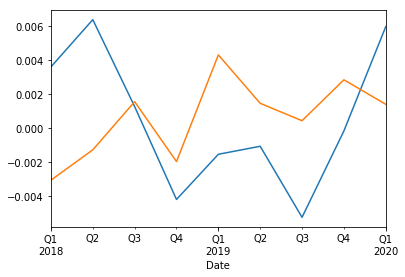

EXTR FEYE


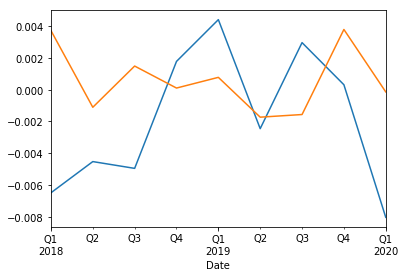

EXTR GPRO


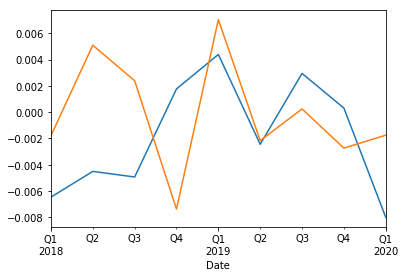

EXTR IONS


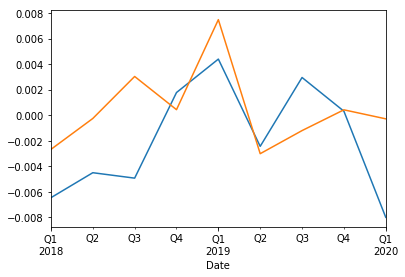

EXTR IPGP


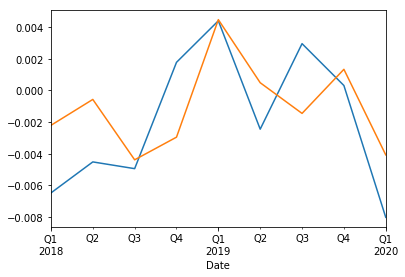

EXTR LBRDA


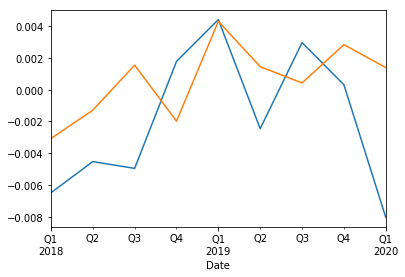

EXTR PSXP


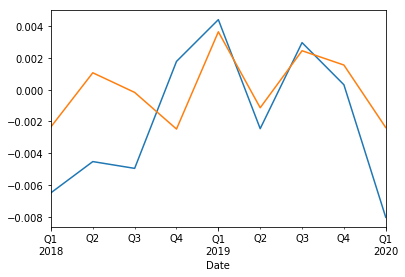

EXTR ROKU


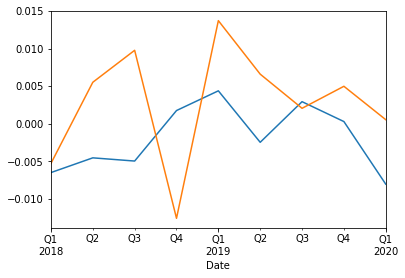

EXTR SGEN


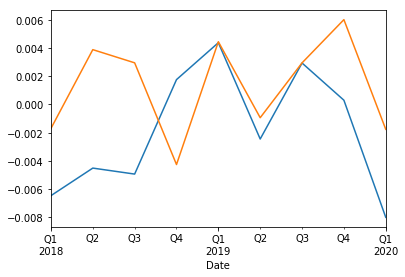

EXTR SRPT


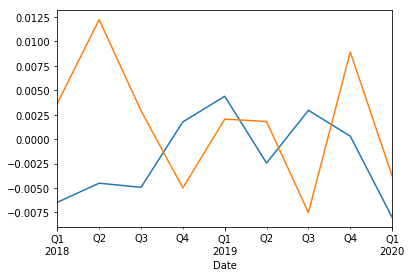

EXTR UI


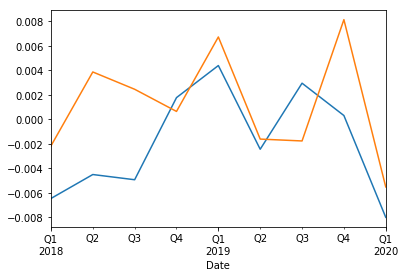

EXTR WST


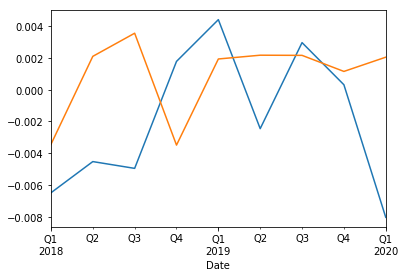

FEYE ROKU


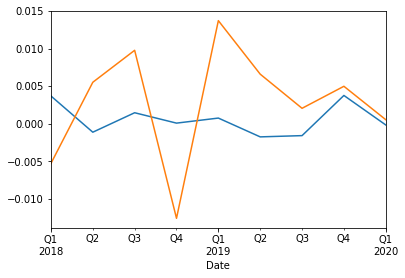

FEYE WST


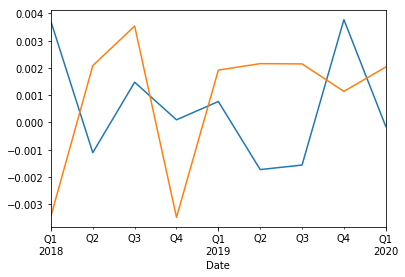

PSXP SGEN


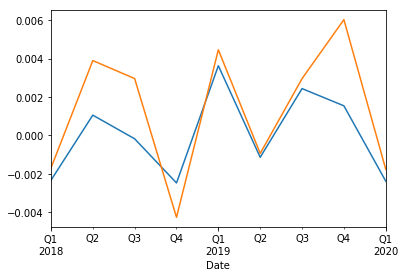

ROKU WST


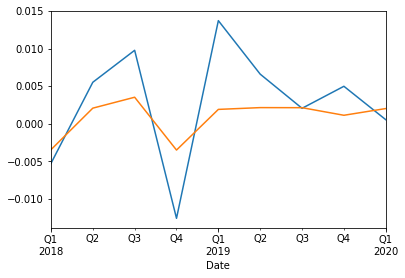

CATS IIPR


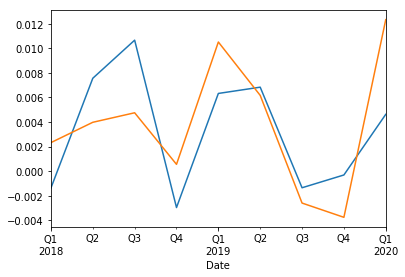

GTYH SLP


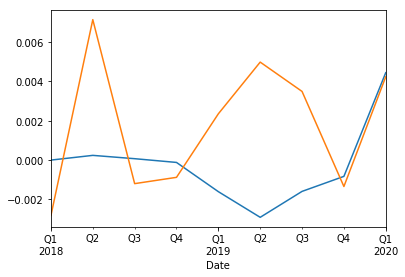

PCSB SIEB


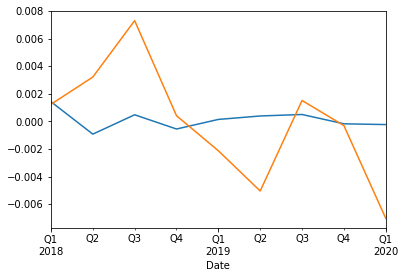

PCSB SLP


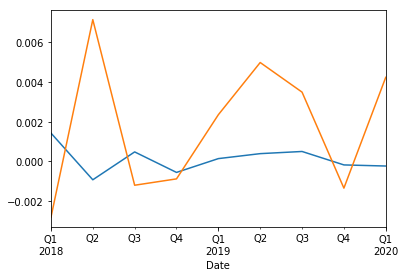

PCSB SSTI


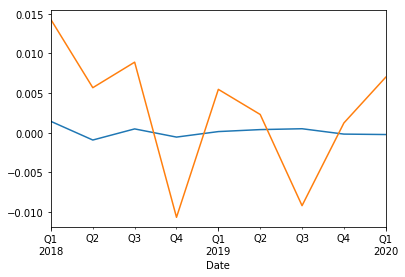

PCSB VERI


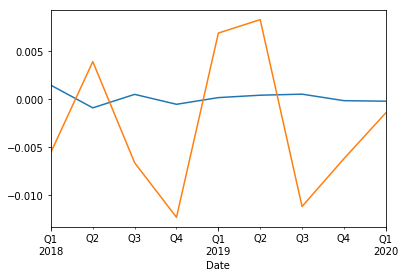

ARGX MRTX


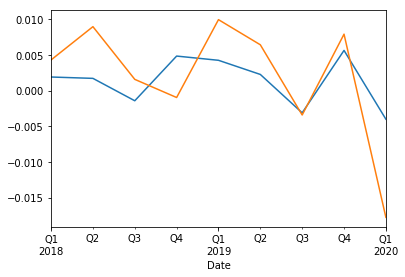

ASND QURE


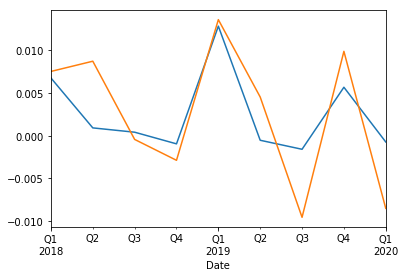

EDIT ITCI


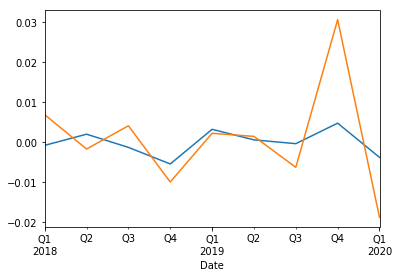

APWC LGL


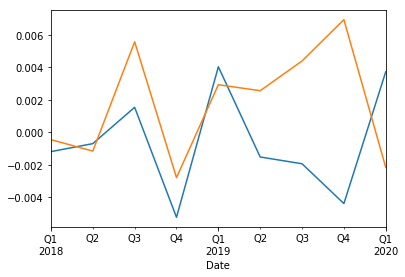

BA TSM


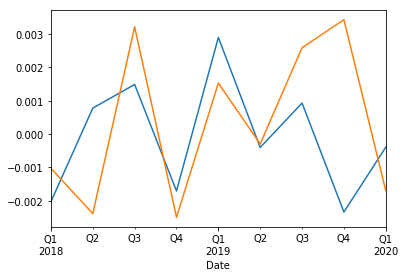

AIG CHL


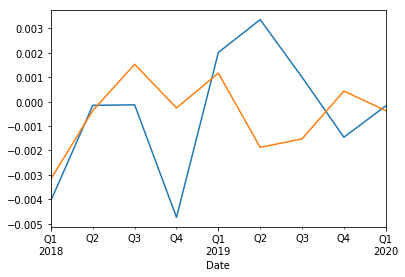

CHL T


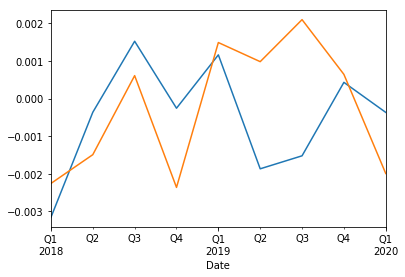

HSBC VZ


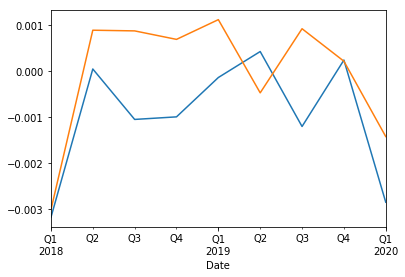

CELH CMCL


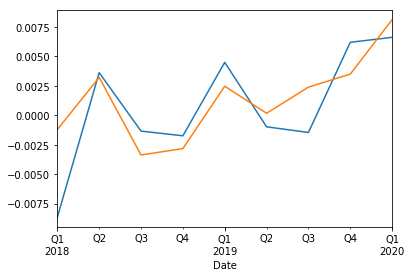

CELH USAS


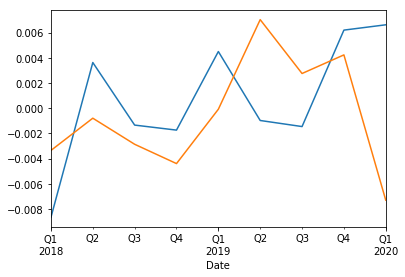

FSBC RAND


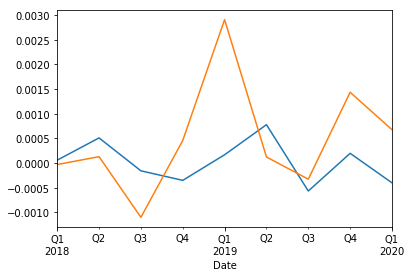

FSBC SELF


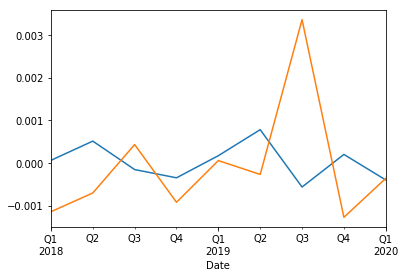

HMG PW


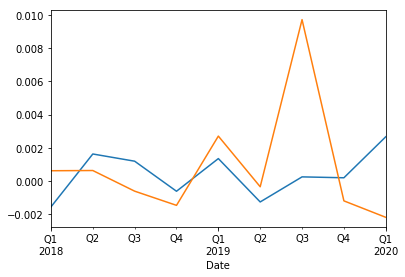

HMG TRMT


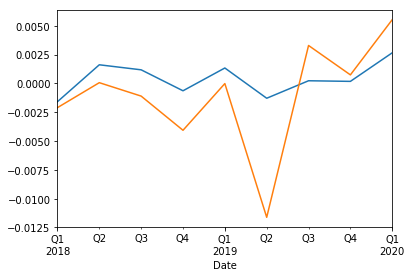

RAND SELF


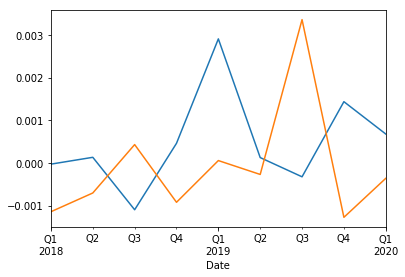

DIS V


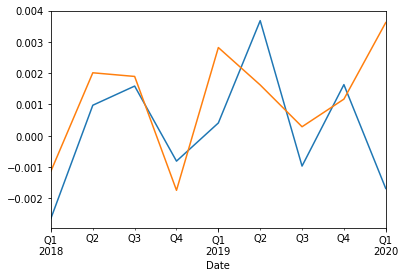

PANL PRTS


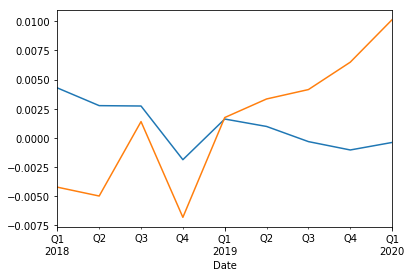

PANL RELL


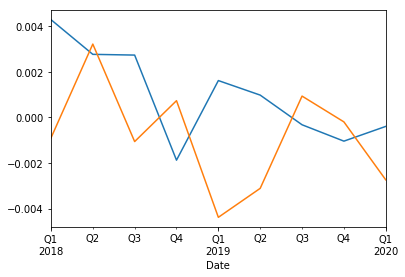

PANL WSTG


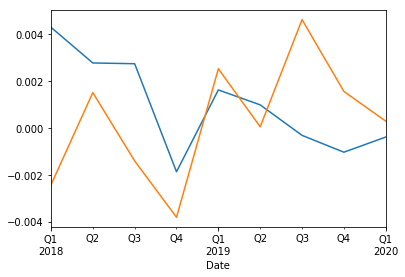

PRTS WSTG


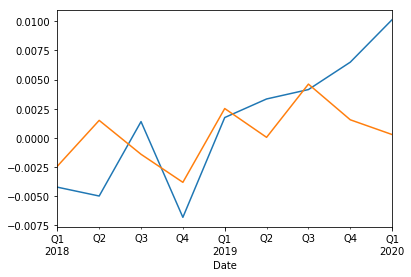

ALJJ CELP


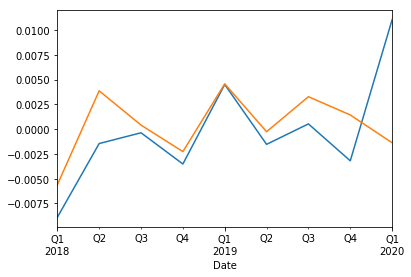

ALJJ DLHC


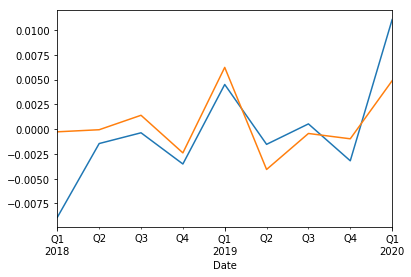

ALJJ PERI


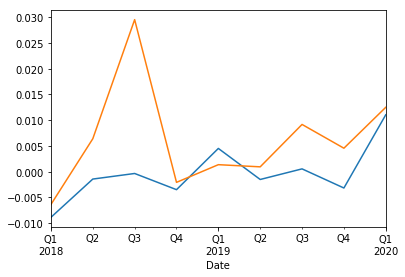

ALJJ RCMT


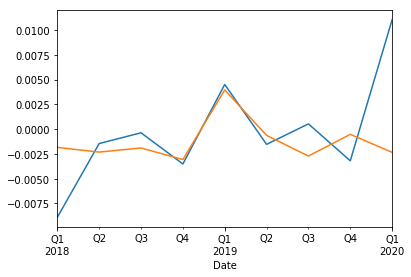

BP XOM


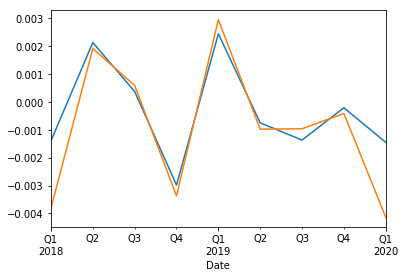

In [313]:
# Plot our pairs
for e in range(len(pairs_dataframe[:])):
             print(pairs_dataframe['tickerA'][e], pairs_dataframe['tickerB'][e])
             quarterly_returns[pairs_dataframe.iloc[:]['tickerA'][e]].plot()
             quarterly_returns[pairs_dataframe.iloc[:]['tickerB'][e]].plot()   
             plt.show()

In [316]:
fundamentals_mongodb = quandl.get_table("SHARADAR/TICKERS", paginate=True)
info_mongodbpairs = pairs_dataframe['tickerA'].append(pairs_dataframe['tickerB'])
info_mongodbpairs = pd.DataFrame(info_mongodbpairs, columns=["ticker"])
info_mongodbpairs = info_mongodbpairs.drop_duplicates(keep='first', inplace=False)
info_mongodbpairs = info_mongodbpairs.merge(fundamentals_mongodb, on='ticker')
info_mongodbpairs = info_mongodbpairs.drop_duplicates(subset='ticker')

In [315]:
info_mongodbpairs.to_csv('info_mongodbpairs.csv')